<a href="https://colab.research.google.com/github/AkramSyed002/Deep-Weed-Segmentation/blob/main/process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#**CREATING PACHES THROUGH YOLO**


## Load drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## import libraries

In [5]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from matplotlib.image import imread
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

## import data

In [2]:

labelFolder = Path('/content/drive/My Drive/research/labels/')
# predFolder = Path('/content/drive/My Drive/research/predLabels/')
predFolder = Path('/content/drive/My Drive/research/predLabelConf0.01/')



## Initilize varaialbles

In [7]:
IMAGE_SIZE = (720, 1280)
THRESHOLD_FOR_PREDICT_CLASSIFIER = [0.2,0.4,0.6]
MERGING_THRESHOLD  = [0.3,0.4,0.5,0.6]
INDEX_NUMBER_NORMAL=0;
INDEX_NUMBER_MERGE=1;

## Save Results

1.   List item
2.   List item



In [8]:
def save_results_with_threshold(finalData, fileName, cmbThresh, resultDir='/content/drive/MyDrive/research/resultsPrAndMerge/'):
    """
    Saves the DataFrame to a CSV file, appending cmbThresh as a percentage to the fileName.

    Parameters:
    - finalData: DataFrame to save.
    - fileName: Base name of the file to save.
    - cmbThresh: Threshold value to append to the fileName, will be converted to percentage.
    - resultDir: Directory where the file will be saved. Default is set to '/content/drive/MyDrive/research/'.
    """
    # Convert cmbThresh to an integer percentage and create the full file path
    filePath = f'{resultDir}{fileName}{cmbThresh * 100}.csv'

    # Save the DataFrame to a CSV file without the index
    finalData.to_csv(filePath, index=False)

    # Optionally, you can print the file path or a success message
    print(f'File saved as: {filePath}')


## Convert  co-ordinates

In [9]:

def convert_labels(im, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (Xmin, Ymin, Xmax, Ymax) annotation format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin

    if type(im) == tuple:
      size = im
    else:
      size = np.shape(im)

    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (x1 + x2)/2.0
    y = (y1 + y2)/2.0
    w = x2 - x1
    h = y2 - y1
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return x, y, w, h

## Yolo file convert to Co-ordinates

In [10]:
def from_yolo_to_cor(box, shape):
    img_h, img_w = shape
    im_w = 1./img_w
    im_h = 1./img_h
    #box = [b/1000 for b in box]
    # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
    # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
    x1, y1 = ((box[0] - box[2]/2)*img_w), ((box[1] - box[3]/2)*img_h)
    x2, y2 = ((box[0] + box[2]/2)*img_w), ((box[1] + box[3]/2)*img_h)
    return round(x1), round(y1), round(x2), round(y2)


## IOU

In [11]:
def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

## Batch IOU

In [12]:
def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    return iou

## Files reading

In [4]:

# labelBoxesFiles = sorted(list(labelFolder.glob('*.txt')))
# predBoxesFiles = sorted(list(predFolder.glob('*.txt')))



# # List all .txt files in each folder
# labelBoxesFiles = sorted(list(labelFolder.glob('*.txt')))
# predBoxesFiles = sorted(list(predFolder.glob('*.txt')))

# # # Extract file names without suffixes for comparison
# # labelFileNames = {file.stem for file in labelBoxesFiles}
# # predFileNames = {file.stem for file in predBoxesFiles}

# # # Filter predBoxesFiles to only include files with names matching those in labelBoxesFiles
# # predBoxesFiles = [file for file in predBoxesFiles if file.stem in labelFileNames]

# # # If you want to keep the matched label files in order or need to filter labelBoxesFiles as well
# # # (in case labelBoxesFiles could have extra files too)
# # labelBoxesFiles = [file for file in labelBoxesFiles if file.stem in predFileNames]

# # # Now matchedPredBoxesFiles contains only the prediction files whose names match with the label files



# # predBoxesFiles = labelBoxesFiles

# labelBoxes = []
# labelStats = []
# predBoxes = []
# predStats = []

# for imageBox in labelBoxesFiles:
#   # print(dataP.as_posix()[:-3] + 'txt')
#   try:
#     df = pd.read_csv(imageBox.as_posix()[:-3] + 'txt', sep=" ", header=None, names=['classID', 'X', 'Y', 'W', 'H'])
#   except:
#     df = pd.DataFrame([])
#     df.names = ['classID', 'X', 'Y', 'W', 'H']
#   labelBoxes.append(df)
#   fileName = imageBox.as_posix().split("/")[-1][:-4]
#   labelStats.append((fileName, len(df) ))
# # print(labelStats[-5:])

# for imageBox in predBoxesFiles:
#   # print(dataP.as_posix()[:-3] + 'txt')
#   try:
#     df = pd.read_csv(imageBox.as_posix()[:-3] + 'txt', sep=" ", header=None, names=['classID', 'X', 'Y', 'W', 'H'])
#   except:
#     df = pd.DataFrame([])
#     df.names = ['classID', 'X', 'Y', 'W', 'H']
#   predBoxes.append(df)
#   fileName = imageBox.as_posix().split("/")[-1][:-4]
#   predStats.append((fileName, len(df) ))


#checing missing fiels

from pathlib import Path
import pandas as pd



# List all .txt files in each folder
labelBoxesFiles = sorted(list(labelFolder.glob('*.txt')))
predBoxesFiles = sorted(list(predFolder.glob('*.txt')))

# Extract file names without suffixes for comparison
labelFileNames = {file.stem for file in labelBoxesFiles}
predFileNames = {file.stem for file in predBoxesFiles}

# Find missing files in predFolder
missingFiles = labelFileNames - predFileNames

# Show the list of missing files
print("Files present in labels but missing in predictions:", missingFiles)

# Create empty files in the prediction folder for missing files
for file in missingFiles:
    filePath = predFolder / f"{file}.txt"
    filePath.touch()

# After this, let's proceed with reading the data
labelBoxes = []
labelStats = []
predBoxes = []
predStats = []

for imageBox in labelBoxesFiles:
    try:
        df = pd.read_csv(imageBox, sep=" ", header=None, names=['classID', 'X', 'Y', 'W', 'H'])
    except:
        df = pd.DataFrame([], columns=['classID', 'X', 'Y', 'W', 'H'])
    labelBoxes.append(df)
    fileName = imageBox.stem
    labelStats.append((fileName, len(df)))

for imageBox in predBoxesFiles:
    try:
        df = pd.read_csv(imageBox, sep=" ", header=None, names=['classID', 'X', 'Y', 'W', 'H'])
    except:
        df = pd.DataFrame([], columns=['classID', 'X', 'Y', 'W', 'H'])
    predBoxes.append(df)
    fileName = imageBox.stem
    predStats.append((fileName, len(df)))

# Now the missing files will be created, and both `labelStats` and `predStats` will be filled accordingly.


Files present in labels but missing in predictions: {'ID_00048_UAV_dji.phantom.4.pro.hawk.1_[Lat=39.54212427861807,Lon=22.64442951302024,Alt=4.900000095367432]_DATE_03_07_2019_14_38_56', 'ID_00049_UAV_dji.phantom.4.pro.hawk.1_[Lat=39.54212238368247,Lon=22.644427100249906,Alt=4.900000095367432]_DATE_03_07_2019_14_38_57'}


In [2]:
predBoxes[0]

NameError: name 'predBoxes' is not defined

## IOU Calcuaiton for files

In [ ]:

## IOU Calculations
fileSelector = 0

A = predBoxes[fileSelector]
B = labelBoxes[fileSelector]
iouList = []
for label in range(len(B)):
    aVec = A.iloc[:].values[:, 1:].tolist()
    bVec = [B.iloc[label][1:].values.tolist()] * len(aVec)

    shape = (1280,720)
    corAvec = np.array([from_yolo_to_cor(a, shape) for a in aVec])
    corBvec = np.array([from_yolo_to_cor(b, shape) for b in bVec])

    iouLabel = batch_iou(corAvec, corBvec, epsilon=0)
    iouList.append(iouLabel)

iouArray = np.array(iouList)
dfIOU = pd.DataFrame(iouArray)


a = labelBoxes[fileSelector].iloc[1][1:].values.tolist()
b = predBoxes[fileSelector].iloc[9][1:].values.tolist()


corA = from_yolo_to_cor(a, shape)
corB = from_yolo_to_cor(b, shape)



iou = get_iou(corA, corB, epsilon=0)

## Compiling Fiels to Data Frame

In [ ]:
labelStatsDF = pd.DataFrame(labelStats)
predStatsDF  = pd.DataFrame(predStats)

## Classifier

In [ ]:
## MAIN Dataset CMBs Classifier

finalData_3D = pd.DataFrame(columns=['WeedID', 'X', 'Y', 'W', 'H' , 'class'])

shape =(720,1280)

# cmbThresh = 0.4
cmbThresh = THRESHOLD_FOR_PREDICT_CLASSIFIER[INDEX_NUMBER_NORMAL]

fpCount = 0
fnCount = 0
tpCount = 0

for index, pred in predStatsDF.iterrows():
  label = labelStatsDF.iloc[index]
  sliceID = '_'.join(label[0].split('_'))

  if(label[1]>0 or pred[1]>0):
    labelCMBs = labelBoxes[index]
    predCMBs  = predBoxes[index]

    if (pred[1] == 0):
      # ALL label CMBs are to be added and labeled as FN / Miss
      # print('False Negative in ' + label[0])
      fnCount = fnCount + label[1]
      for lcmb in range(label[1]):
        sData = labelCMBs.iloc[[lcmb]].drop(columns='classID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %lcmb
        cmb['class'] = 'FN'
        # finalData_3D = pd.concat([finalData_3D, cmb], ignore_index=True)
        finalData_3D = pd.concat([finalData_3D, pd.DataFrame([cmb])], ignore_index=True)
        # print(str(index) + ' : ' + str(lcmb) + ' is FN.')

    elif (label[1] == 0):
      # ALL pred CMBs are labeled as FP / False Alarm
      # print('False Positive in ' + pred[0])
      fpCount = fpCount + pred[1]
      for pcmb in range(pred[1]):
        sData = predCMBs.iloc[[pcmb]].drop(columns='classID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %pcmb
        cmb['class'] = 'FP'
        # finalData_3D = pd.concat([finalData_3D, cmb], ignore_index=True)
        finalData_3D = pd.concat([finalData_3D, pd.DataFrame([cmb])], ignore_index=True)
        # print(str(index) + ' : ' + str(pcmb) + ' is FP.')

    else:
      # for iCMB, predCMB in predCMBs.iterrows():
      # print('More work needs to be done in ' + pred[0])

      cmbN = []
      for pcmb in range(pred[1]):
        tpCheck = 0

        sData = predCMBs.iloc[[pcmb]].drop(columns='classID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %pcmb

        for lcmb in range(label[1]):
          # '''
          # Find IOU with all true labels, if found to greater than cmbThresh, it
          # is TP otherwise FP
          # '''

          if (pcmb == pred[1]-1):
            aVec = predCMBs.iloc[:].values[:, 1:].tolist()
            bVec = [labelCMBs.iloc[lcmb][1:].values.tolist()] * len(aVec)

            corAvec = np.array([from_yolo_to_cor(a, shape) for a in aVec])
            corBvec = np.array([from_yolo_to_cor(b, shape) for b in bVec])

            # if index == 329:
            #   print(corAvec)
            #   print(corBvec)
            #   batchIoU = batch_iou(corAvec, corBvec, epsilon=0)
            #   print(batchIoU)

            if (np.sum(batch_iou(corAvec, corBvec, epsilon=0) < cmbThresh) == len(aVec)):
              # print(labelCMBs.iloc[lcmb])
              cmbN.append(labelCMBs.iloc[lcmb][1:].values.tolist())

          a = predCMBs.iloc[pcmb][1:].values.tolist()
          b = labelCMBs.iloc[lcmb][1:].values.tolist()

          corA = from_yolo_to_cor(a, shape)
          corB = from_yolo_to_cor(b, shape)

          iou = get_iou(corA, corB, epsilon=0)

          if (iou > cmbThresh):
            tpCount = tpCount + 1
            tpCheck = 1
            break

        if (tpCheck):
          cmb['class'] = 'TP'
          # print(str(index) + ' : ' + str(pcmb) + ' is TP.')
        else:
          fpCount = fpCount + 1
          cmb['class'] = 'FP'
          # print(str(index) + ' : ' + str(pcmb) + ' is FP.')
        # finalData_3D = finalData_3D.append(pd.DataFrame([cmb])   , ignore_index=True)
        finalData_3D = pd.concat([finalData_3D, pd.DataFrame([cmb])], ignore_index=True)


        if (len(cmbN) > 0):
          cols = labelCMBs.columns[1:]
          for icmb, lcmb in enumerate(cmbN):
            cmbn = {cols[col]:lcmb[col] for col in range(len(cols))}
            cmbn['WeedID'] = sliceID + '_%02d' %(icmb+pred[1])
            # print('False Negative at ' + str(cmbn['CMBid']))
            cmbn['class'] = 'FN'
            fnCount = fnCount + 1
            # finalData_3D = finalData_3D.append(cmbn , ignore_index=True)
            finalData_3D = pd.concat([finalData_3D, pd.DataFrame([cmbn])], ignore_index=True)

print('\n\n\n WeedID Classification Results:')
print('##################################')
print('False Positives Found = ' + str(fpCount))
print('False Negatives Found = ' + str(fnCount))
print('True Positives Found  = ' + str(tpCount))

fileName = "predClassifier_"


save_results_with_threshold(finalData_3D, fileName, cmbThresh)


# finalData_3D




 WeedID Classification Results:
##################################
False Positives Found = 1861
False Negatives Found = 13
True Positives Found  = 1145
File saved as: /content/drive/MyDrive/research/resultsPrAndMerge/predClassifier_20.0.csv


In [ ]:
resultDir = '/content/drive/MyDrive/research/'

In [ ]:
# finalData_3D = pd.read_csv(f'{resultDir}predClassifier_{cmbThresh * 100}.csv')
# finalData_3D

In [ ]:
# # Assuming finalData_3D is your DataFrame and you want to filter rows where the 'class' column is 'TP'
# data_filtered = finalData_3D[finalData_3D['class'] == 'TP']

# # Now, getting the length (count of rows) of the filtered DataFrame
# count = len(data_filtered)

# print(count)


## FN, FP AND TP COUNTS

In [ ]:
print(f"False Negative (FN) = {len(finalData_3D[finalData_3D['class'] == 'FN'])}")
print(f"False Positive (FP) = {len(finalData_3D[finalData_3D['class'] == 'FP'])}")
print(f"True Positive  (TP) = {len(finalData_3D[finalData_3D['class'] == 'TP'])}")

False Negative (FN) = 13
False Positive (FP) = 1861
True Positive  (TP) = 1145


## READING DATA SET

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CoFly-WeedDB'
# save_dir = '../data/CoFly-WeedDB/boxes'
# yolo_dir =  '../data/CoFly-WeedDB/yolo/'

# binary = 1


images_path = data_dir + '/images'
masks_path = data_dir + '/labels'

# Create a Path object for the folder
imagesList = Path(images_path)
masksList = Path(masks_path)


masks = np.array(sorted([str(item) for item in sorted(masksList.iterdir()) if item.is_file()]))

images = np.array(sorted([str(item) for item in sorted(imagesList.iterdir())
                  if (item.is_file())]))


# print(masks.shape)
# print(images.shape)


imageName = [image.split("/")[-1] for image in images]
maskName = [mask.split("/")[-1] for mask in masks]

notMask = [image for image in imageName if image not in maskName]
# notMask=[]
# for image in imageName:
#     if image not in maskName:
#         notMask.append(image)

imagesF = np.array([image for image in images if image.split('/')[-1] not in notMask],ndmin=1).T
masksF = np.array(masks, ndmin=1).T


## DRAW BOXES

In [ ]:



def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image

    Parameters
    ----------

    im : numpy.ndarray
        numpy image

    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`

    Returns
    -------

    numpy.ndarray
        numpy image with bounding boxes drawn on it

    """

    im = im.copy()

    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:

        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])

        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])

        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

## PLOTING RESULT

/content/drive/MyDrive/Colab Notebooks/CoFly-WeedDB/images/ID_00407_UAV_dji.phantom.4.pro.hawk.1_[Lat=39.541758292161155,Lon=22.644408826234198,Alt=5.0]_DATE_03_07_2019_14_50_58.png >>>>>>file name
   classID         X        Y         W         H
0        0  0.918359  0.86875  0.107031  0.209722
True Boxes:
[[[1107  550 1244  701]]]


Predicted Boxes:
[[[1074  525 1271  701]]

 [[ 350   60  720  458]]

 [[1109  536 1255  710]]

 [[   1   72  206  575]]

 [[ 337   51  737  597]]

 [[ 833  124  986  328]]

 [[   2  198  283  688]]]


TP Boxes:
[[[1074  525 1271  701]]

 [[1109  536 1255  710]]]




FP Boxes:
[[[350  60 720 458]]

 [[  1  72 206 575]]

 [[337  51 737 597]]

 [[833 124 986 328]]

 [[  2 198 283 688]]]


FN Boxes:
[]


Plot results:
#########################



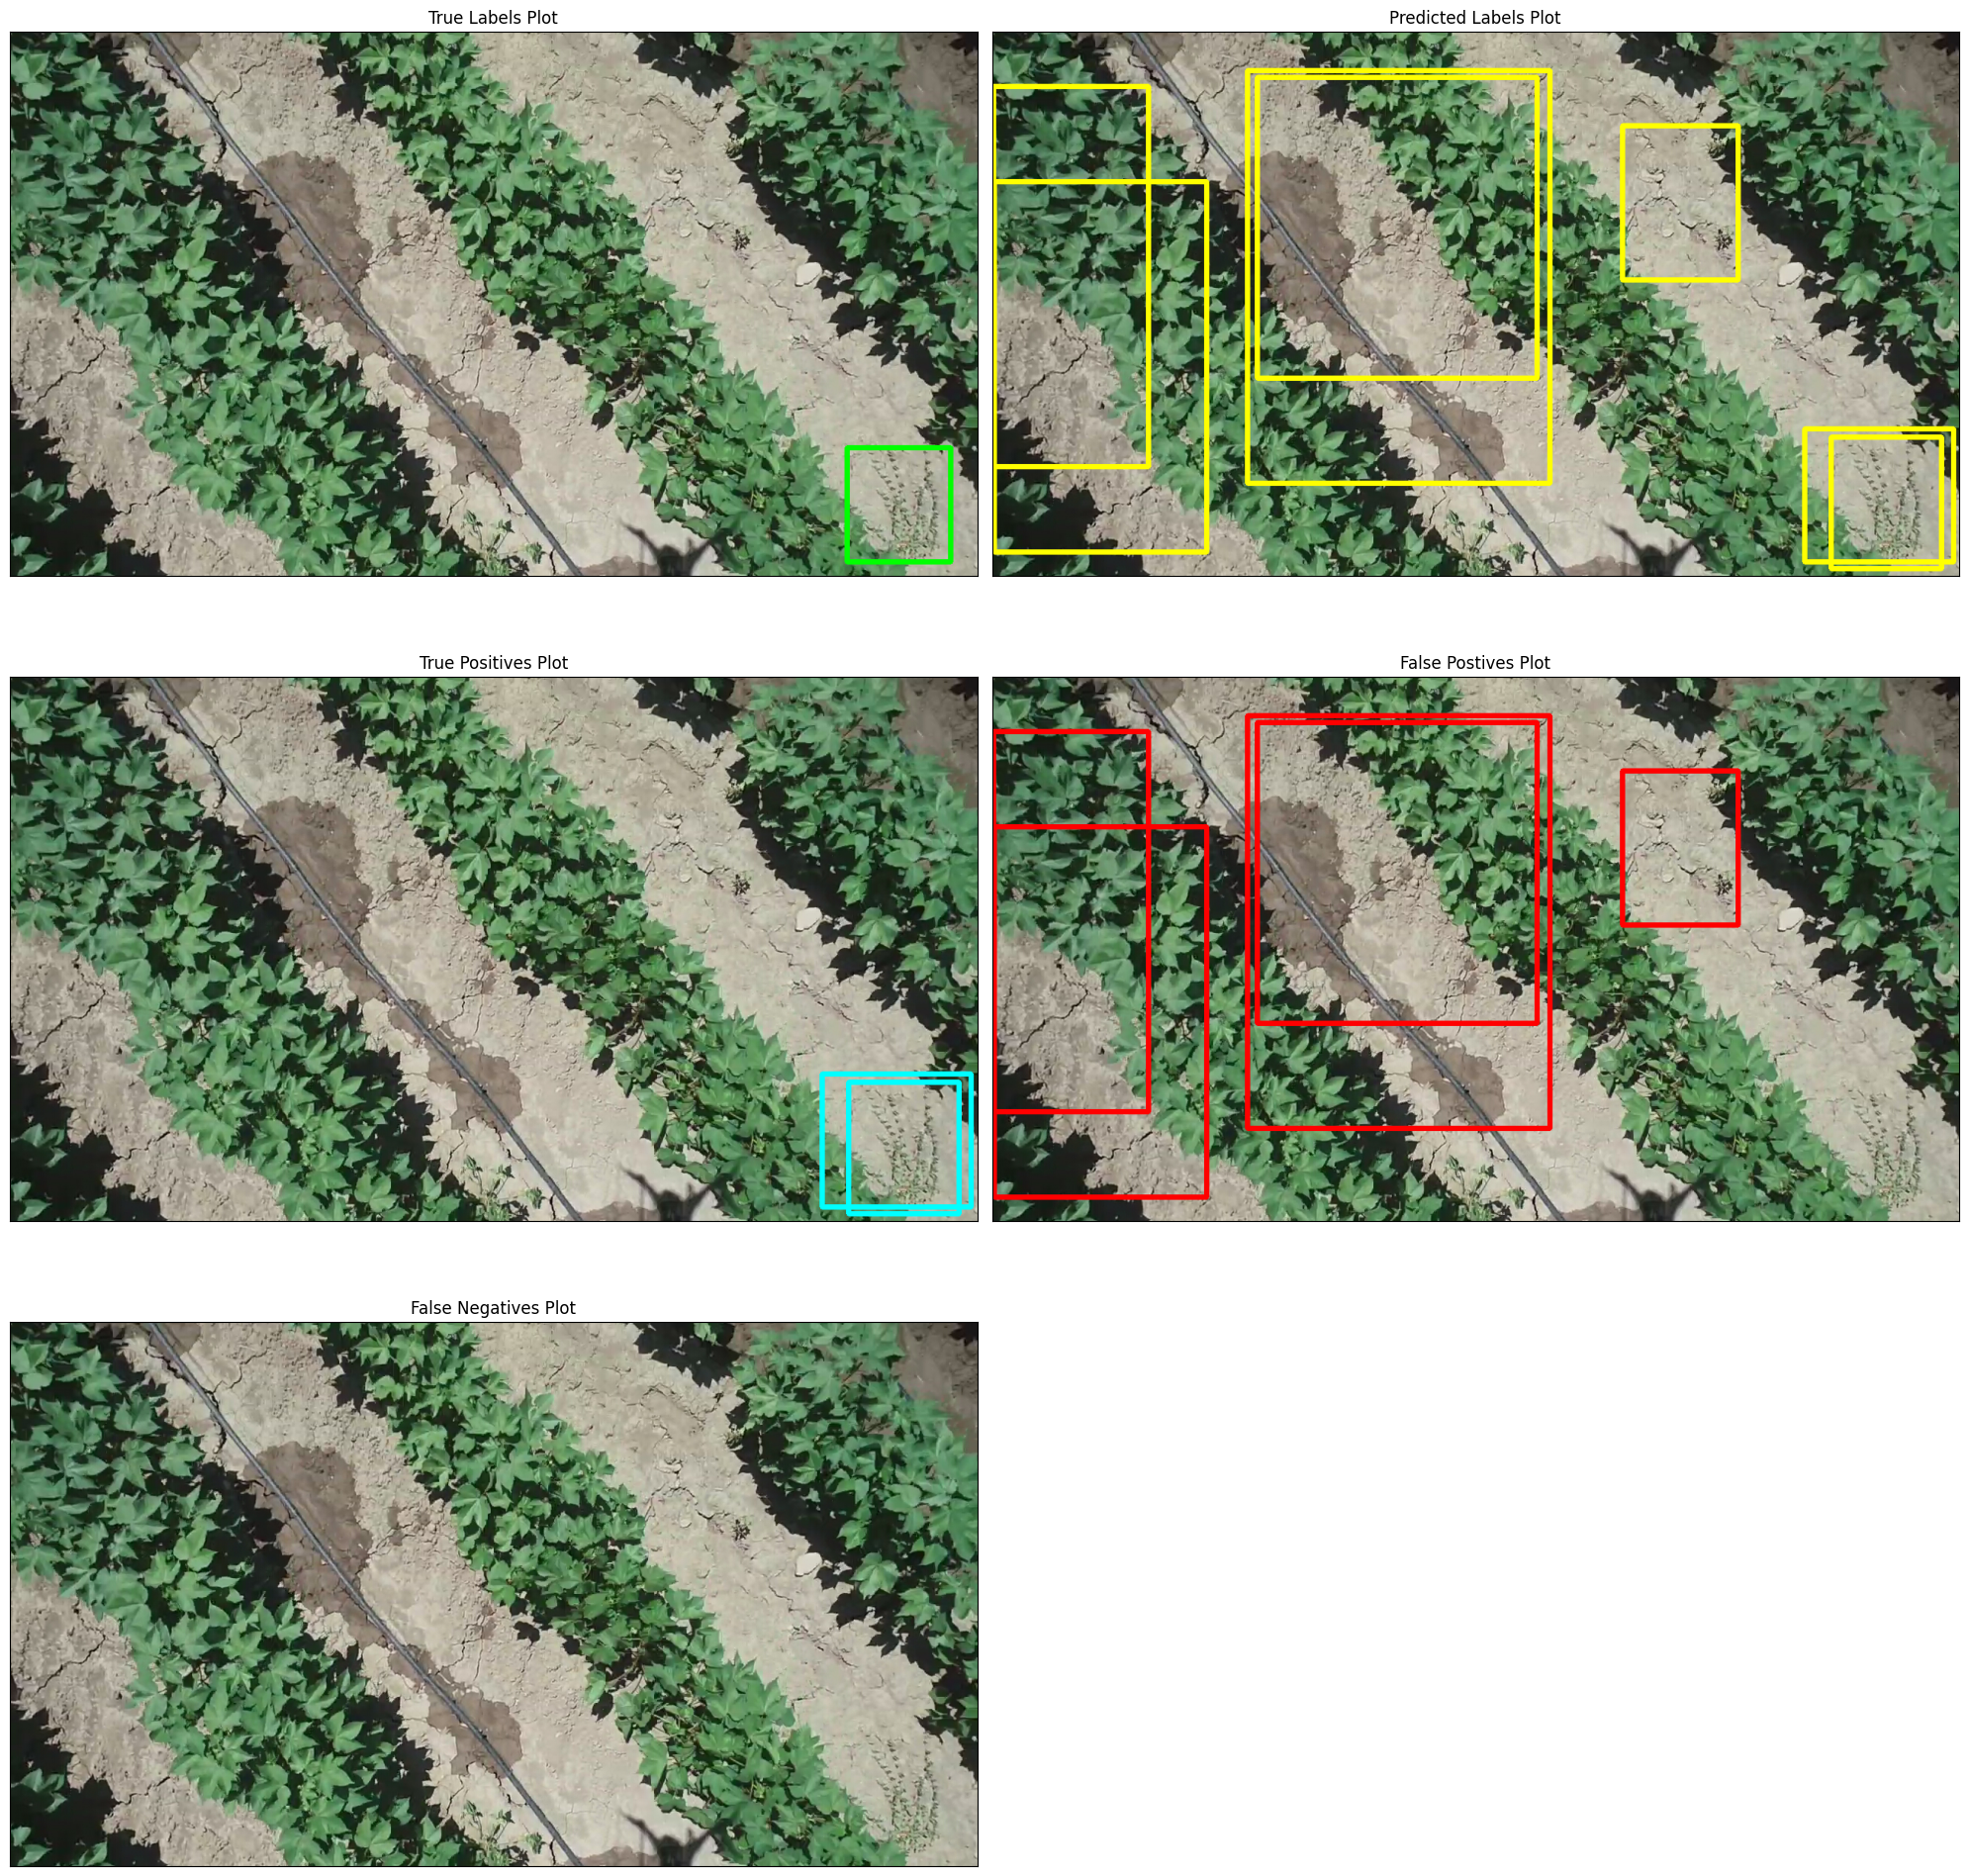

In [ ]:


sliceN =200





fig = plt.figure(tight_layout='auto', figsize=(20, 20))
img = imread(imagesF[sliceN])
print(imagesF[sliceN],">>>>>>file name")
fig.add_subplot(3,2,1)

lVec = labelBoxes[sliceN].iloc[:].values[:, 1:].tolist()
print(labelBoxes[sliceN])
bboxes = np.array([from_yolo_to_cor(box, shape) for box in lVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('True Boxes:')
print(bboxes)
plt.title('True Labels Plot')
plotted_img = draw_rect(img, bboxes, color=[0,255,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)

fig.add_subplot(3,2,2)

pVec = predBoxes[sliceN].iloc[:].values[:, 1:].tolist()

bboxes = np.array([from_yolo_to_cor(box, shape) for box in pVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nPredicted Boxes:')
print(bboxes)
plt.title('Predicted Labels Plot')
plotted_img = draw_rect(img, bboxes, color=[255,255,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)

fig.add_subplot(3,2,3)

# tpVec = [a[1:5] for a in finalData_3D.values.tolist() if (a[0][:-3] == '_'.join(labelTestStatsDF[0].iloc[sliceN].split('_')[:-1])) & (a[5] == 'TP')]
tpVec = [a[1:5] for a in finalData_3D.values.tolist() if (a[0][:-3] == '_'.join(labelStatsDF[0].iloc[sliceN].split('_'))) & (a[5] == 'TP')]


bboxes = np.array([from_yolo_to_cor(box, shape) for box in tpVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nTP Boxes:')
print(bboxes)
plt.title('True Positives Plot')
plotted_img = draw_rect(img, bboxes, color=[0,255,255])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)

fig.add_subplot(3,2,4)

# fpVec = [a[1:5] for a in finalData_3D.values.tolist() if (a[0][:-3] == '_'.join(labelTestStatsDF[0].iloc[sliceN].split('_')[:-1])) & (a[5] == 'FP')]
fpVec = [a[1:5] for a in finalData_3D.values.tolist() if (a[0][:-3] == '_'.join(labelStatsDF[0].iloc[sliceN].split('_'))) & (a[5] == 'FP')]


bboxes = np.array([from_yolo_to_cor(box, shape) for box in fpVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nFP Boxes:')
print(bboxes)
plt.title('False Postives Plot')
plotted_img = draw_rect(img, bboxes, color=[255,0,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)

fig.add_subplot(3,2,5)

fnVec = [a[1:5] for a in finalData_3D.values.tolist() if (a[0][:-3] == '_'.join(labelStatsDF[0].iloc[sliceN].split('_'))) & (a[5] == 'FN')]

bboxes = np.array([from_yolo_to_cor(box, shape) for box in fnVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nFN Boxes:')
print(bboxes)
plt.title('False Negatives Plot')

plotted_img = draw_rect(img, bboxes, color=[0,0,255])
plt.imshow(plotted_img)
print('\n\nPlot results:\n#########################\n')
plt.xticks([])
plt.yticks([])
plt.show()


## PREDECTIED TP,TN AND FP

In [ ]:
subList = []
fnList  = []
fpList  = []
tpList  = []

finalData_3D_Sub = pd.DataFrame(columns=['Subject', 'TP', 'FP', 'FN', 'Pred_Weeds'])
shape = (720,1280)

for img in imagesF:
  subData = [weed for weed in finalData_3D.values.tolist() if '_'.join(weed[0].split('_')[:-1])==img.split('/')[-1][:-4]]
  # print(subData)
  subDataCor = [[box[0], from_yolo_to_cor(box[1:5], shape), box[5]] for box in subData]
  fnData  = [fn  for fn in subDataCor if fn[2] == 'FN']
  fpData  = [fp  for fp in subDataCor if fp[2] == 'FP']
  tpData  = [tp  for tp in subDataCor if tp[2] == 'TP']

  subList.append(subDataCor)
  fData = {}

  if len(fnData) > 0:
    fnList.append(fnData)
  if len(fpData) > 0:
    fpList.append(fpData)
  if (len(tpData) > 0):
    tpList.append(tpData)

  fData['Subject'] = img.split('/')[-1]
  fData['Pred_Weeds'] = len(subDataCor) - len(fnData)
  fData['TP'] = len(tpData)
  fData['FP'] = len(fpData)
  fData['FN'] = len(fnData)
  # finalData_3D_Sub = finalData_3D_Sub.append(fData , ignore_index=True)

  #Start AS i change here to remove the error
  finalData_3D_Sub = pd.concat([finalData_3D_Sub, pd.DataFrame([fData])], ignore_index=True)
  #End


# print(subList)
# print(fnList)
# print(fpList)
# print(tpList)
print('\n\n\nCMBs Classified as subject-wise and class-wise ')
finalData_3D_Sub
fileName = "predClassifierStat_"


save_results_with_threshold(finalData_3D_Sub, fileName, THRESHOLD_FOR_PREDICT_CLASSIFIER[INDEX_NUMBER_NORMAL])





CMBs Classified as subject-wise and class-wise 
File saved as: /content/drive/MyDrive/research/resultsPrAndMerge/predClassifierStat_20.0.csv


need to save the above

In [ ]:
sliceN

200

## MERGING BOXES

## DBSCAN TO MERGE OVERLAPS for one Image

---



In [ ]:
## CMB IOU Comparison for all

# pd.reset_option('^display.', silent=True)
iouV = pd.DataFrame(columns=['(weedA, weedB)',  'weedA', 'weedB', 'iou'])
# sliceN = 1
thresh   = MERGING_THRESHOLD[INDEX_NUMBER_MERGE]

# for df in predBoxes:
df = predBoxes[sliceN]
cmbC  = len(df)
  # iouV  = np.zeros((cmbC, cmbC))
shape = (720,1280)

for r in np.arange(cmbC):
  for c in np.arange(cmbC):
    if r < c:
      cmbV = dict()
      a = df.iloc[r][1:].values.tolist()
      b = df.iloc[c][1:].values.tolist()

      corA = from_yolo_to_cor(a, shape)
      corB = from_yolo_to_cor(b, shape)


      cmbV['(weedA, weedB)'] = (r, c)
      cmbV['weedA'] = corA
      cmbV['weedB'] = corB
      cmbV['iou'] = get_iou(corA, corB, epsilon=0)
      iouV = pd.concat([iouV, pd.DataFrame([cmbV])] , ignore_index=True)

# thresh = 0.4
# significant_overlaps = iouV[iouV['iou']>thresh]
# significant_overlaps

iou_data = iouV


# Step 1: Collect all unique boxes
all_boxes = []
[all_boxes.append(tuple(box)) for box in iou_data['weedA'].tolist() + iou_data['weedB'].tolist() if tuple(box) not in all_boxes]

# Convert to a format suitable for DBSCAN (a list of lists)
all_boxes_list = [list(box) for box in all_boxes]

# Step 2: Define a function to compute the distance matrix based on IoU, inverted since DBSCAN expects distances
def compute_distance_matrix(boxes):
    n = len(boxes)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            # Here, you should replace 'get_iou' with your actual IoU calculation function
            iou = get_iou(boxes[i], boxes[j], epsilon=0)  # Assuming this function exists
            distance = 1 - iou  # Inverting IoU to use as distance
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    return distance_matrix

# Compute distance matrix for DBSCAN
distance_matrix = compute_distance_matrix(all_boxes_list)

# Step 3: Apply DBSCAN to cluster boxes based on their "distance" (inverted IoU)
dbscan = DBSCAN(eps=1-thresh, min_samples=1, metric="precomputed")  # eps should be tuned to your specific case
clusters = dbscan.fit_predict(distance_matrix)

# Step 4: Merge boxes within each cluster
merged_boxes = []
for cluster_id in np.unique(clusters):
    indices = np.where(clusters == cluster_id)[0]
    cluster_boxes = [all_boxes_list[index] for index in indices]
    # Merging strategy: Use the minimum start coordinates and maximum end coordinates
    x_min = min(box[0] for box in cluster_boxes)
    y_min = min(box[1] for box in cluster_boxes)
    x_max = max(box[2] for box in cluster_boxes)
    y_max = max(box[3] for box in cluster_boxes)
    merged_boxes.append([x_min, y_min, x_max, y_max])

# merged_boxes now contains the merged bounding boxes
len(merged_boxes)

4

## PLOTING FILE AFTER MERGING

/content/drive/MyDrive/Colab Notebooks/CoFly-WeedDB/images/ID_00407_UAV_dji.phantom.4.pro.hawk.1_[Lat=39.541758292161155,Lon=22.644408826234198,Alt=5.0]_DATE_03_07_2019_14_50_58.png >>>>>>file name
   classID         X        Y         W         H
0        0  0.918359  0.86875  0.107031  0.209722
True Boxes:
[[[1107  550 1244  701]]]


Predicted Boxes:
[[[1074  525 1271  701]]

 [[ 350   60  720  458]]

 [[1109  536 1255  710]]

 [[   1   72  206  575]]

 [[ 337   51  737  597]]

 [[ 833  124  986  328]]

 [[   2  198  283  688]]]


Merged Boxes:
[[[1074  525 1271  710]]

 [[ 337   51  737  597]]

 [[   1   72  283  688]]

 [[ 833  124  986  328]]]


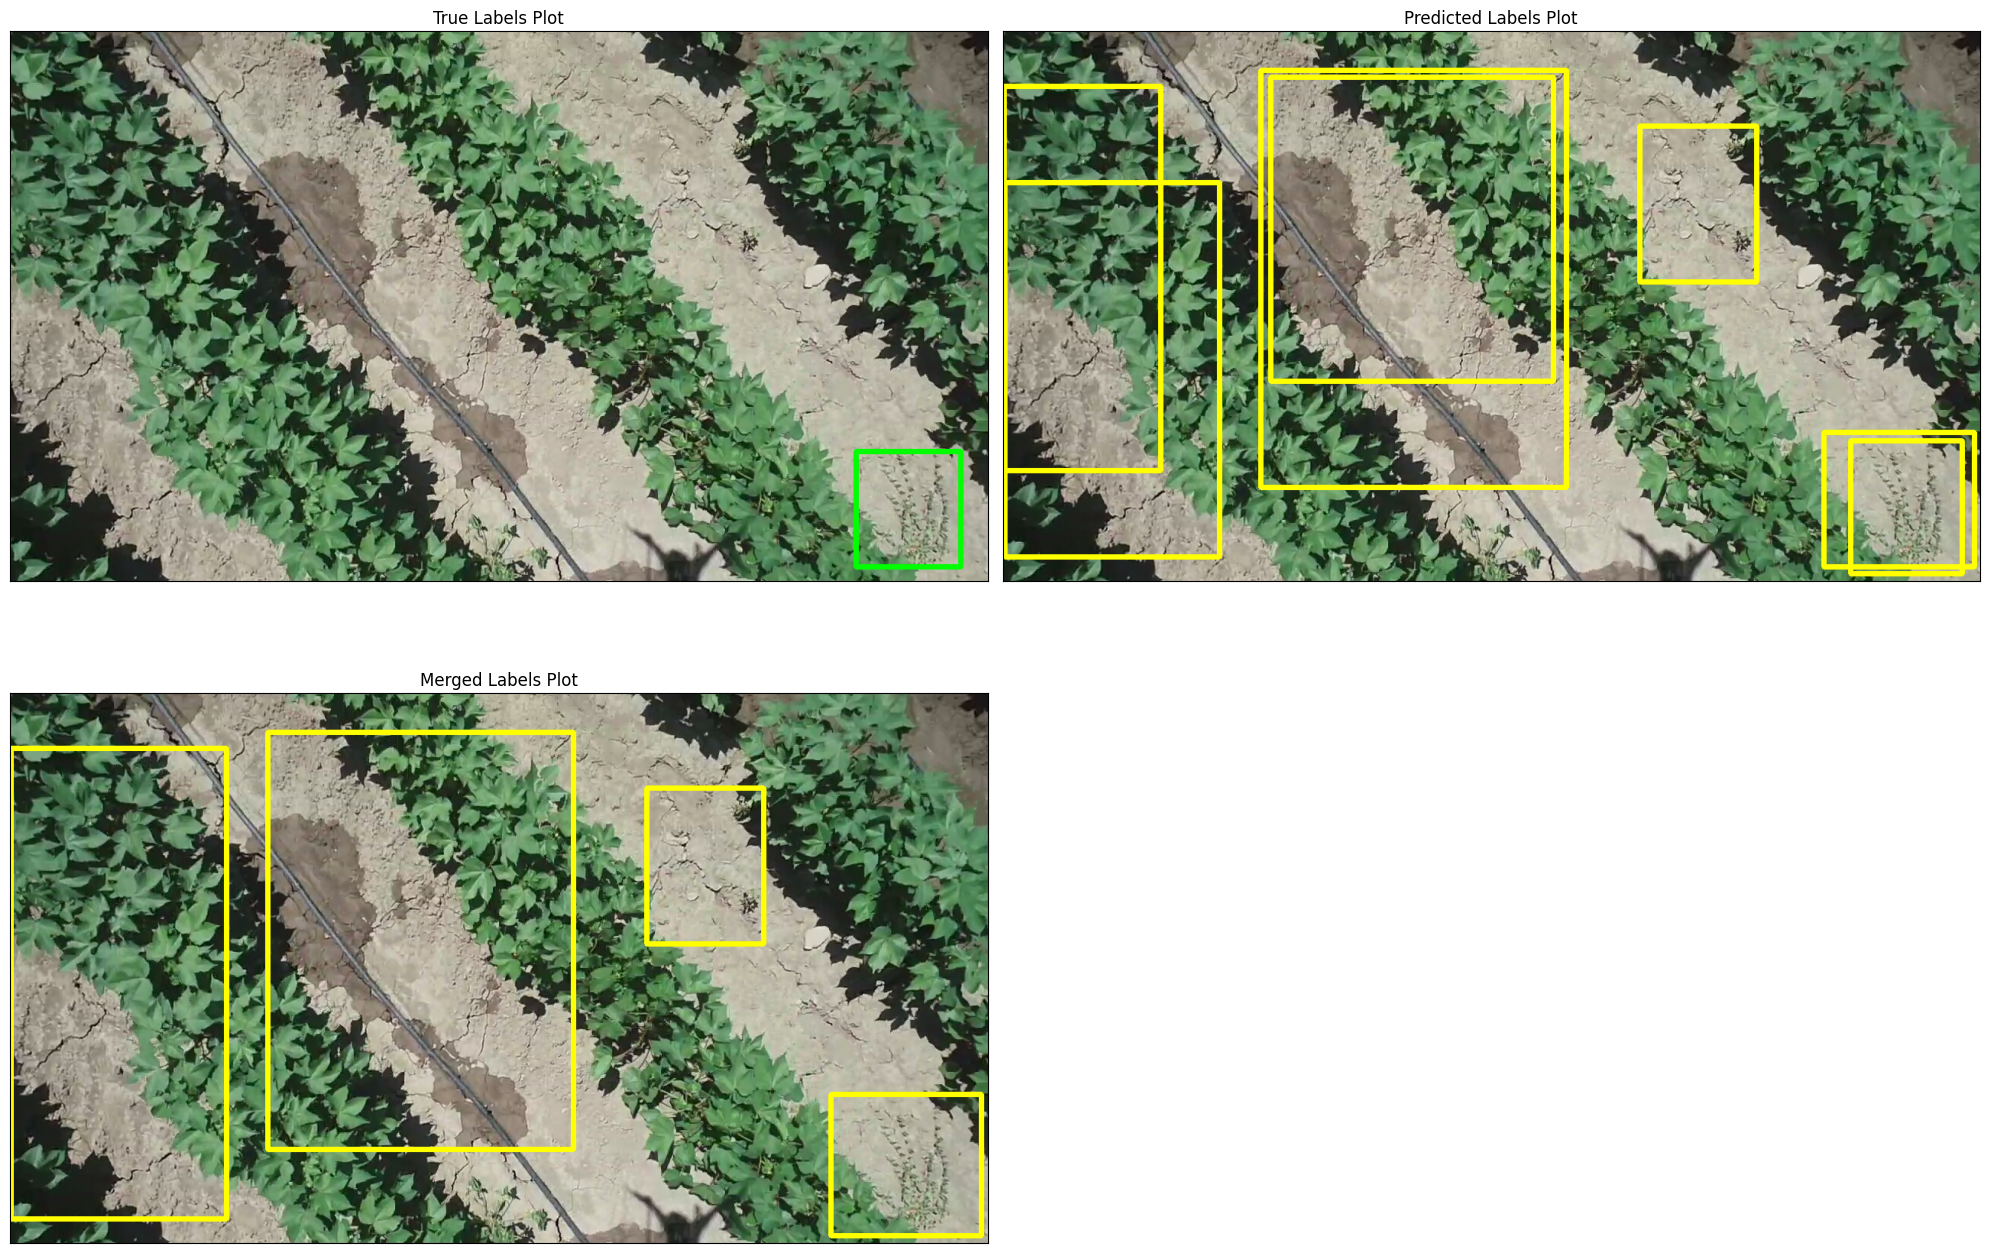

In [ ]:
# sliceN = 200
fig = plt.figure(tight_layout='auto', figsize=(20, 20))
img = plt.imread(imagesF[sliceN])
print(imagesF[sliceN],">>>>>>file name")
fig.add_subplot(3,2,1)

lVec = labelBoxes[sliceN].iloc[:].values[:, 1:].tolist()
print(labelBoxes[sliceN])
bboxes = np.array([from_yolo_to_cor(box, shape) for box in lVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('True Boxes:')
print(bboxes)
plt.title('True Labels Plot')
plotted_img = draw_rect(img, bboxes, color=[0,255,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)

fig.add_subplot(3,2,2)

pVec = predBoxes[sliceN].iloc[:].values[:, 1:].tolist()

bboxes = np.array([from_yolo_to_cor(box, shape) for box in pVec])[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nPredicted Boxes:')
print(bboxes)
plt.title('Predicted Labels Plot')
plotted_img = draw_rect(img, bboxes, color=[255,255,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)



fig.add_subplot(3,2,3)

# pVec = predBoxes[sliceN].iloc[:].values[:, 1:].tolist()

# bboxes = np.array([from_yolo_to_cor(box, shape) for box in pVec])[:,np.newaxis]

bboxes = np.array(merged_boxes)[:,np.newaxis]

# bboxes = labelTest[sliceN].iloc[:].values.tolist()[1:]
# bboxes = np.array(from_yolo_to_cor(bboxes, shape))[:,np.newaxis].T

print('\n\nMerged Boxes:')
print(bboxes)
plt.title('Merged Labels Plot')
plotted_img = draw_rect(img, bboxes, color=[255,255,0])
plt.xticks([])
plt.yticks([])
plt.imshow(plotted_img)


## All Image Boxes Results Applying DBSCAN

In [ ]:
## CMB IOU Comparison for all

# pd.reset_option('^display.', silent=True)

# sliceN = 5
shape = (720,1280)

mergedBoxes = []
mergedStats = []

# thresh = 0.2
thresh=MERGING_THRESHOLD[INDEX_NUMBER_MERGE]

for i, df in enumerate(predBoxes):
  weed  = len(df)
  iouV = pd.DataFrame(columns=['(weedA, weedB)',  'weedA', 'weedB', 'iou'])

  # print(f'Working on image {i} out of {len(predBoxes)}.')
  # iouV  = np.zeros((cmbC, cmbC))

  for r in np.arange(weed):
    for c in np.arange(weed):
      if r < c:
        cmbV = dict()
        a = df.iloc[r][1:].values.tolist()
        b = df.iloc[c][1:].values.tolist()

        corA = from_yolo_to_cor(a, shape)
        corB = from_yolo_to_cor(b, shape)


        cmbV['(weedA, weedB)'] = (r, c)
        cmbV['weedA'] = corA
        cmbV['weedB'] = corB
        cmbV['iou'] = get_iou(corA, corB, epsilon=0)
        iouV = pd.concat([iouV, pd.DataFrame([cmbV])] , ignore_index=True)




  iou_data = iouV

  # Step 1: Collect all unique boxes
  all_boxes = []
  [all_boxes.append(tuple(box)) for box in iou_data['weedA'].tolist() + iou_data['weedB'].tolist() if tuple(box) not in all_boxes]

  # Convert to a format suitable for DBSCAN (a list of lists)
  all_boxes_list = [list(box) for box in all_boxes]

  # Step 2: Define a function to compute the distance matrix based on IoU, inverted since DBSCAN expects distances
  def compute_distance_matrix(boxes):
      n = len(boxes)
      distance_matrix = np.zeros((n, n))
      for i in range(n):
          for j in range(i + 1, n):
              # Here, you should replace 'get_iou' with your actual IoU calculation function
              iou = get_iou(boxes[i], boxes[j], epsilon=0)  # Assuming this function exists
              distance = 1 - iou  # Inverting IoU to use as distance
              distance_matrix[i, j] = distance_matrix[j, i] = distance
      return distance_matrix

  # Compute distance matrix for DBSCAN
  distance_matrix = compute_distance_matrix(all_boxes_list)

  # Step 3: Apply DBSCAN to cluster boxes based on their "distance" (inverted IoU)
  dbscan = DBSCAN(eps=1-thresh, min_samples=1, metric="precomputed")  # eps should be tuned to your specific case
  clusters = dbscan.fit_predict(distance_matrix)

  # Step 4: Merge boxes within each cluster
  merged_boxes = []
  for cluster_id in np.unique(clusters):
      indices = np.where(clusters == cluster_id)[0]
      cluster_boxes = [all_boxes_list[index] for index in indices]
      # Merging strategy: Use the minimum start coordinates and maximum end coordinates
      x_min = min(box[0] for box in cluster_boxes)
      y_min = min(box[1] for box in cluster_boxes)
      x_max = max(box[2] for box in cluster_boxes)
      y_max = max(box[3] for box in cluster_boxes)

      box = convert_labels(shape, x_min, y_min, x_max, y_max)
      # box = convert_labels(plt.imread(imagesF[i]), x_min, y_min, x_max, y_max)
      box = [0] + list(box)

      merged_boxes.append(box)

  # merged_boxes now contains the merged bounding boxes
  mergedStats.append((predStatsDF[0].iloc[i], len(merged_boxes)))

  mergedBoxes.append(pd.DataFrame(merged_boxes, columns=['WeedID','X','Y','W','H']))

# thresh = 0.4
# significant_overlaps = iouV[iouV['iou']>thresh]
# significant_overlaps

In [ ]:
mergedStatsDF = pd.DataFrame(mergedStats)


## Classifer after Merged

In [ ]:
## MAIN Dataset CMBs Classifier

finalData_M3D = pd.DataFrame(columns=['WeedID', 'X', 'Y', 'W', 'H' , 'class'])

shape =(720,1280)

# cmbThresh = 0.4
cmbThresh=THRESHOLD_FOR_PREDICT_CLASSIFIER[INDEX_NUMBER_NORMAL]
fpCount = 0
fnCount = 0
tpCount = 0

for index, pred in mergedStatsDF.iterrows():
  label = labelStatsDF.iloc[index]
  sliceID = '_'.join(label[0].split('_'))

  if(label[1]>0 or pred[1]>0):
    labelCMBs = labelBoxes[index]
    predCMBs  = mergedBoxes[index]

    if (pred[1] == 0):
      # ALL label CMBs are to be added and labeled as FN / Miss
      # print('False Negative in ' + label[0])
      fnCount = fnCount + label[1]
      for lcmb in range(label[1]):
        sData = labelCMBs.iloc[[lcmb]].drop(columns='classID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %lcmb
        cmb['class'] = 'FN'
        # finalData_3D = pd.concat([finalData_3D, cmb], ignore_index=True)
        finalData_M3D = pd.concat([finalData_M3D, pd.DataFrame([cmb])], ignore_index=True)
        # print(str(index) + ' : ' + str(lcmb) + ' is FN.')

    elif (label[1] == 0):
      # ALL pred CMBs are labeled as FP / False Alarm
      # print('False Positive in ' + pred[0])
      fpCount = fpCount + pred[1]
      for pcmb in range(pred[1]):
        sData = predCMBs.iloc[[pcmb]].drop(columns='classID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %pcmb
        cmb['class'] = 'FP'
        # finalData_3D = pd.concat([finalData_3D, cmb], ignore_index=True)
        finalData_M3D = pd.concat([finalData_M3D, pd.DataFrame([cmb])], ignore_index=True)
        # print(str(index) + ' : ' + str(pcmb) + ' is FP.')

    else:
      # for iCMB, predCMB in predCMBs.iterrows():
      # print('More work needs to be done in ' + pred[0])

      cmbN = []
      for pcmb in range(pred[1]):
        tpCheck = 0

        sData = predCMBs.iloc[[pcmb]].drop(columns='WeedID')
        cmb = {col:sData[col].values[0] for col in sData.columns}
        cmb['WeedID'] = sliceID + '_%02d' %pcmb

        for lcmb in range(label[1]):
          # '''
          # Find IOU with all true labels, if found to greater than cmbThresh, it
          # is TP otherwise FP
          # '''

          if (pcmb == pred[1]-1):
            aVec = predCMBs.iloc[:].values[:, 1:].tolist()
            bVec = [labelCMBs.iloc[lcmb][1:].values.tolist()] * len(aVec)

            corAvec = np.array([from_yolo_to_cor(a, shape) for a in aVec])
            corBvec = np.array([from_yolo_to_cor(b, shape) for b in bVec])

            # if index == 329:
            #   print(corAvec)
            #   print(corBvec)
            #   batchIoU = batch_iou(corAvec, corBvec, epsilon=0)
            #   print(batchIoU)

            if (np.sum(batch_iou(corAvec, corBvec, epsilon=0) < cmbThresh) == len(aVec)):
              # print(labelCMBs.iloc[lcmb])
              cmbN.append(labelCMBs.iloc[lcmb][1:].values.tolist())

          a = predCMBs.iloc[pcmb][1:].values.tolist()
          b = labelCMBs.iloc[lcmb][1:].values.tolist()

          corA = from_yolo_to_cor(a, shape)
          corB = from_yolo_to_cor(b, shape)

          iou = get_iou(corA, corB, epsilon=0)

          if (iou > cmbThresh):
            tpCount = tpCount + 1
            tpCheck = 1
            break

        if (tpCheck):
          cmb['class'] = 'TP'
          # print(str(index) + ' : ' + str(pcmb) + ' is TP.')
        else:
          fpCount = fpCount + 1
          cmb['class'] = 'FP'
          # print(str(index) + ' : ' + str(pcmb) + ' is FP.')
        # finalData_3D = finalData_3D.append(pd.DataFrame([cmb])   , ignore_index=True)
        finalData_M3D = pd.concat([finalData_M3D, pd.DataFrame([cmb])], ignore_index=True)


        if (len(cmbN) > 0):
          cols = labelCMBs.columns[1:]
          for icmb, lcmb in enumerate(cmbN):
            cmbn = {cols[col]:lcmb[col] for col in range(len(cols))}
            cmbn['WeedID'] = sliceID + '_%02d' %(icmb+pred[1])
            # print('False Negative at ' + str(cmbn['CMBid']))
            cmbn['class'] = 'FN'
            fnCount = fnCount + 1
            # finalData_3D = finalData_3D.append(cmbn , ignore_index=True)
            finalData_M3D = pd.concat([finalData_M3D, pd.DataFrame([cmbn])], ignore_index=True)

print('\n\n\n WeedID Classification Results:')
print('##################################')
print('False Positives Found = ' + str(fpCount))
print('False Negatives Found = ' + str(fnCount))
print('True Positives Found  = ' + str(tpCount))
finalData_M3D

# fileName = "predMergeClassifier_MT_"+MERGING_THRESHOLD[INDEX_NUMBER_MERGE]+"CT_"
fileName = "predMergeClassifier_MT_" + str(MERGING_THRESHOLD[INDEX_NUMBER_MERGE]) + "CT_"


save_results_with_threshold(finalData_M3D, fileName, cmbThresh)




 WeedID Classification Results:
##################################
False Positives Found = 859
False Negatives Found = 27
True Positives Found  = 421
File saved as: /content/drive/MyDrive/research/resultsPrAndMerge/predMergeClassifier_MT_0.4CT_20.0.csv


In [ ]:
subList = []
fnList  = []
fpList  = []
tpList  = []

finalData_M3D_Sub = pd.DataFrame(columns=['Subject', 'TP', 'FP', 'FN', 'Pred_Weeds'])
shape = (720,1280)

for img in imagesF:
  subData = [weed for weed in finalData_M3D.values.tolist() if '_'.join(weed[0].split('_')[:-1])==img.split('/')[-1][:-4]]
  # print(subData)
  subDataCor = [[box[0], from_yolo_to_cor(box[1:5], shape), box[5]] for box in subData]
  fnData  = [fn  for fn in subDataCor if fn[2] == 'FN']
  fpData  = [fp  for fp in subDataCor if fp[2] == 'FP']
  tpData  = [tp  for tp in subDataCor if tp[2] == 'TP']

  subList.append(subDataCor)
  fData = {}

  if len(fnData) > 0:
    fnList.append(fnData)
  if len(fpData) > 0:
    fpList.append(fpData)
  if (len(tpData) > 0):
    tpList.append(tpData)

  fData['Subject'] = img.split('/')[-1]
  fData['Pred_Weeds'] = len(subDataCor) - len(fnData)
  fData['TP'] = len(tpData)
  fData['FP'] = len(fpData)
  fData['FN'] = len(fnData)
  # finalData_3D_Sub = finalData_3D_Sub.append(fData , ignore_index=True)

  #Start AS i change here to remove the error
  finalData_M3D_Sub = pd.concat([finalData_M3D_Sub, pd.DataFrame([fData])], ignore_index=True)
  #End


# print(subList)
# print(fnList)
# print(fpList)
# print(tpList)
print('\n\n\nCMBs Classified as subject-wise and class-wise ')
finalData_M3D_Sub

# fileName = "predMergeClassifierStat_MT_"

fileName = "predMergeClassifierStat_MT_"+str(MERGING_THRESHOLD[INDEX_NUMBER_MERGE])+"CT_"



save_results_with_threshold(finalData_M3D_Sub, fileName, cmbThresh)




CMBs Classified as subject-wise and class-wise 
File saved as: /content/drive/MyDrive/research/resultsPrAndMerge/predMergeClassifierStat_MT_0.4CT_20.0.csv


TESTING

In [ ]:
mergedStatsDF = pd.DataFrame(mergedStats)
mergedStatsDF

0   1
0    ID_00048_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  14
1    ID_00049_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   5
2    ID_00050_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  11
3    ID_00051_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   9
4    ID_00052_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  18
..                                                 ...  ..
196  ID_00380_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   2
197  ID_00385_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   3
198  ID_00404_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   3
199  ID_00405_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   7
200  ID_00407_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....   4

[201 rows x 2 columns]